In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rss-top-performers-prediction/task.csv
/kaggle/input/rss-top-performers-prediction/course.csv
/kaggle/input/rss-top-performers-prediction/sampleSubmission.csv
/kaggle/input/rss-top-performers-prediction/train.csv
/kaggle/input/rss-top-performers-prediction/test.csv
/kaggle/input/rss-top-performers-prediction/task_results.csv


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier, ElasticNetCV, LogisticRegression, RidgeClassifier, SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBRFClassifier, XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsClassifier


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
train_data = pd.read_csv('/kaggle/input/rss-top-performers-prediction/train.csv', parse_dates=True)
test_data = pd.read_csv('/kaggle/input/rss-top-performers-prediction/test.csv', parse_dates=True)
sample = pd.read_csv('/kaggle/input/rss-top-performers-prediction/sampleSubmission.csv')
task_result = pd.read_csv('/kaggle/input/rss-top-performers-prediction/task_results.csv', parse_dates=True)
course_data = pd.read_csv('/kaggle/input/rss-top-performers-prediction/course.csv', parse_dates=True)
task_data = pd.read_csv('/kaggle/input/rss-top-performers-prediction/task.csv', parse_dates=True)

In [5]:
# посмотрим на данные датасета
train_data.head()

,studentId,createdDate,updatedDate,isExpelled,expellingReason,courseCompleted,isTopPerformer,preferedMentorGithubId,readyFullTime,courseId,...,hiredById,hiredByName,isFailed,startDate,endDate,repository,repositoryLastActivityDate,idUser,educationHistory,englishLevel
0,5740,2019-09-06 17:30:17.681556,2019-12-03 16:24:58.705742,t,No activity in private repository,f,True,NaN,NaN,11,...,NaN,NaN,f,2019-09-09 07:35:20.981+00,2019-12-04 09:17:02.998689+00,https://github.com/rolling-scopes-school/1b3f6...,NaN,4467,[],NaN
1,6956,2019-09-09 18:24:04.90096,2019-11-20 22:00:13.036321,t,No activity in private repository,f,True,NaN,NaN,11,...,NaN,NaN,f,2019-09-09 07:35:20.981+00,2019-12-04 09:17:02.998689+00,https://github.com/rolling-scopes-school/76c0e...,NaN,5580,[],NaN
2,11616,2020-02-05 12:39:48.166948,2020-02-05 12:39:48.166948,f,NaN,f,False,NaN,NaN,16,...,NaN,NaN,f,2020-02-05 12:39:48.164+00,NaN,NaN,NaN,9557,[],NaN
3,11773,2020-02-05 17:16:46.874484,2020-02-05 17:16:46.874484,f,NaN,f,False,NaN,NaN,16,...,NaN,NaN,f,2020-02-05 17:16:46.872+00,NaN,NaN,NaN,9627,"[{""graduationYear"":null,""faculty"":null,""univer...",b1
4,6724,2019-09-09 17:06:56.967084,2020-01-19 16:55:12.069984,t,Failed Stage 2,f,True,NaN,NaN,11,...,NaN,NaN,f,2019-09-09 07:35:20.981+00,1970-01-01 00:00:00+00,https://github.com/rolling-scopes-school/7fb23...,NaN,5390,[],NaN


In [6]:
# проверим число отсутствующих значений в тренировочном и тестовом датасете
train_data.isna().sum()

studentId                         0
createdDate                       0
updatedDate                       0
isExpelled                        0
expellingReason                5011
courseCompleted                   0
isTopPerformer                    0
preferedMentorGithubId        10471
readyFullTime                 10470
courseId                          0
userId                            0
mentorId                       7862
cvUrl                         10471
hiredById                     10471
hiredByName                   10471
isFailed                          0
startDate                         0
endDate                        1439
repository                     8961
repositoryLastActivityDate    10100
idUser                            0
educationHistory                  0
englishLevel                   5059
dtype: int64

In [7]:
test_data.isna().sum()

studentId                        0
createdDate                      0
updatedDate                      0
isExpelled                       0
expellingReason               2991
courseCompleted                  0
preferedMentorGithubId        2991
readyFullTime                 2991
courseId                         0
userId                           0
mentorId                      2524
cvUrl                         2991
hiredById                     2991
hiredByName                   2991
isFailed                         0
startDate                        0
endDate                       2991
repository                    2704
repositoryLastActivityDate    2913
idUser                           0
educationHistory                 0
englishLevel                  1496
dtype: int64

после просмотра колонок с отсутствующими значениями было решено отбросить следующие колонки: 
* expellingReason (данные об отчислении есть в колонке "isExpelled")
* preferedMentorGithubId (предпочтительный ментор - пока нет причины считать, что этот признак даст нам лучшее предсказание)
* readyFullTime (в данном столбце есть только одно уникальное значение - 'f', часть значений не заполнена, т.е. = Nan)
* mentorId (по той же причине, что и "preferedMentorGithubId")
* cvUrl (это скорее всего ссылка на резюме, т.к. она не заполнена, тоже не имеет смысла)
* hiredById (это скорее всего ID того, кто взял на курс студента, т.к. она не заполнена, тоже не имеет смысла)
* hiredByName (это скорее всего имя того, кто взял на курс студента, т.к. она не заполнена, тоже не имеет смысла)
* endDate (дата окончания (курса?) - пока нет причины считать, что этот признак даст нам лучшее предсказание)
* repository (ссылка на репозиторий также не даст нам улучшения предсказания, т.к. отсутствующие значения есть и при **train_data.isTopPerformer == True]**)
* repositoryLastActivityDate (дата последнего обновления репозитория также не даст нам улучшения предсказания, т.к. больашя часть отсутствующих значений есть при **train_data.isTopPerformer == True]**)
* englishLevel (уровень английского имеет много уровней, а также отсутствующие значения и в **train_data.isTopPerformer == True]**)

In [8]:
# разделим искомое значение и тренировочные данные
#y = train_data['isTopPerformer']
#train_data = train_data.drop('isTopPerformer', axis=1)

In [9]:
# т.к. отсутствующие значение есть в одних и тех же столбцах на тренировочных и тестовых данных, то отбросим эти значения
drop_list_nan = []
for i in train_data.columns:
    if train_data[i].isna().sum() > 0:
        drop_list_nan.append(i)

In [10]:
train_data = train_data.drop(drop_list_nan, axis=1)
test_data = test_data.drop(drop_list_nan, axis=1)

In [11]:
# посмотрим на данные
train_data.head()

,studentId,createdDate,updatedDate,isExpelled,courseCompleted,isTopPerformer,courseId,userId,isFailed,startDate,idUser,educationHistory
0,5740,2019-09-06 17:30:17.681556,2019-12-03 16:24:58.705742,t,f,True,11,4467,f,2019-09-09 07:35:20.981+00,4467,[]
1,6956,2019-09-09 18:24:04.90096,2019-11-20 22:00:13.036321,t,f,True,11,5580,f,2019-09-09 07:35:20.981+00,5580,[]
2,11616,2020-02-05 12:39:48.166948,2020-02-05 12:39:48.166948,f,f,False,16,9557,f,2020-02-05 12:39:48.164+00,9557,[]
3,11773,2020-02-05 17:16:46.874484,2020-02-05 17:16:46.874484,f,f,False,16,9627,f,2020-02-05 17:16:46.872+00,9627,"[{""graduationYear"":null,""faculty"":null,""univer..."
4,6724,2019-09-09 17:06:56.967084,2020-01-19 16:55:12.069984,t,f,True,11,5390,f,2019-09-09 07:35:20.981+00,5390,[]


Следует отбросить также значения "idUser" т.к. оно дублирует колонку "userId", а также нет смысла в колонке "courseCompleted", т.к. она имеет одно значение - **"f"**.
Колонка "educationHistory" пока также отбрасывается, т.к. в тренировочных данных более 6000 значений заполнено символом **"[]"**.

In [12]:
drop_list_useless = ['idUser', 'courseCompleted', 'educationHistory']
train_data = train_data.drop(drop_list_useless, axis=1)
test_data = test_data.drop(drop_list_useless, axis=1)

In [13]:
#посмотрим на данные по оценке заданий
task_result.head()

,createdDate,updatedDate,score,comment,studentId,courseTaskId,historicalScores,juryScores,checkerId,anonymous
0,2019-09-19 18:36:46.232791,2019-09-19 18:36:46.232791,100,NaN,7266,300,"[{""authorId"":0,""score"":100,""dateTime"":15689182...",[],NaN,NaN
1,2019-10-02 12:48:27.977059,2019-10-21 09:58:59.674519,41,NaN,7929,313,"[{""authorId"":0,""score"":38,""dateTime"":157002050...",[],NaN,NaN
2,2019-10-08 15:05:43.777805,2019-10-08 15:05:43.777805,100,NaN,6134,308,"[{""authorId"":0,""score"":100,""dateTime"":15705471...",[],NaN,NaN
3,2019-10-11 15:03:28.245927,2019-10-11 15:03:28.245927,100,NaN,5882,305,"[{""authorId"":0,""score"":100,""dateTime"":15708062...",[],NaN,NaN
4,2019-10-12 16:31:57.699719,2019-10-12 16:31:57.699719,100,NaN,8247,305,"[{""authorId"":0,""score"":100,""dateTime"":15708979...",[],NaN,NaN


In [14]:
task_result.isna().sum()

createdDate             0
updatedDate             0
score                   0
comment             53392
studentId               0
courseTaskId            0
historicalScores        0
juryScores          23852
checkerId           70410
anonymous           70410
dtype: int64

In [15]:
# отбросим колонки с отсутствующими значениями, по сути нас интересует только колонка "score"
drop_list_task = []
for i in task_result.columns:
    if task_result[i].isna().sum() > 0:
        drop_list_task.append(i)

In [16]:
task_result = task_result.drop(drop_list_task, axis=1)
# также отбросим колонку "historicalScores"
#task_result = task_result.drop('historicalScores', axis=1)

In [17]:
# добавим реальный максимальный балл в данные с результатами по выполненным заданиям, а также 'scoreWeight','courseEndDate'
task_result = task_result.merge(task_data[['courseTaskId', 'maxScore', 'scoreWeight','courseEndDate']], how='left', on='courseTaskId')

In [18]:
# переведем дату в число
date_list_task = ['createdDate', 'updatedDate', 'courseEndDate']
for x in date_list_task:
    task_result[x]= pd.to_datetime(task_result[x]).dt.strftime("%y%m%d").astype(int)

In [19]:
# также переведем дату в число на тренировочных и тестовых данных
date_list_train = ['createdDate', 'updatedDate', 'startDate']
for x in date_list_train:
    train_data[x]= pd.to_datetime(train_data[x]).dt.strftime("%y%m%d").astype(int)
    test_data[x]= pd.to_datetime(test_data[x]).dt.strftime("%y%m%d").astype(int)

In [20]:
# определим количество пройденных курсов при количестве баллов от 0 до 10000
plot_graph = pd.DataFrame(columns=['score', 'number_course'])
for x,i in enumerate(range(0, 10000, 100)):
    plot_graph.loc[x] = (i, task_result[task_result.score > i].courseTaskId.nunique())

In [21]:
# как видно из таблицы, при увеличении оценки более 1000 количество пройденных курсов резко снижается
plot_graph[plot_graph.number_course>1]

,score,number_course
0,0,276
1,100,94
2,200,30
3,300,14
4,400,14
5,500,10
6,600,9
7,700,9
8,800,9
9,900,9


<AxesSubplot:xlabel='score', ylabel='number_course'>

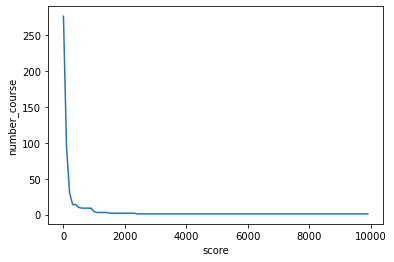

In [22]:
sns.lineplot(x=plot_graph.score.astype('int'), y=plot_graph.number_course.astype('int'))

<AxesSubplot:ylabel='score'>

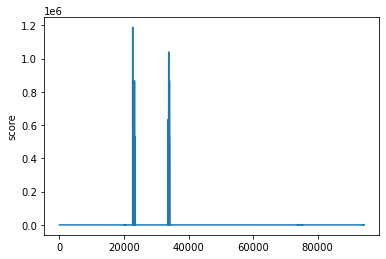

In [23]:
#посмотрим значения "score" в task_result
sns.lineplot(x=task_result.index, y=task_result.score)

In [24]:
# как видно из графика и из минимальных и максимальных значений, есть выбросы. Попробуем их отбросить.
task_result.score.max(), task_result.score.min(), task_result.score.mean(), task_result.score.median()

(1188820, -50, 251.72986993698416, 97.0)

In [25]:
#task_result = task_result.drop(index=task_result[task_result.score > 5000].index)
task_result = task_result.drop(index=task_result[task_result.score < 0].index)

In [26]:
# проверим значения
task_result.score.max(), task_result.score.min(), task_result.score.mean(), task_result.score.median()

(1188820, 0, 251.76121208263044, 97.0)

In [27]:
# создадим таблицу с метриками скора и количеством курсов по каждому студенту для тренировочных данных
mean_score_train = pd.DataFrame(columns=['studentId', 'mean_score', '100_score', '200_score', '300_score', '400_score',
                                         '500_score','max_score', 'count_course', 'real_score', 'mean_weight', 'courseEndDate'])
for x,i in enumerate(train_data.studentId):
    mean_score_train.loc[x] = i, task_result[task_result.studentId == i]['score'].mean(),\
    task_result[(task_result.studentId == i)&(task_result.score>99)]['score'].count(),\
    task_result[(task_result.studentId == i)&(task_result.score>199)]['score'].count(),\
    task_result[(task_result.studentId == i)&(task_result.score>299)]['score'].count(),\
    task_result[(task_result.studentId == i)&(task_result.score>399)]['score'].count(),\
    task_result[(task_result.studentId == i)&(task_result.score>499)]['score'].count(),\
    task_result[task_result.studentId == i]['score'].max(),\
    task_result[task_result.studentId == i]['courseTaskId'].count(),\
    task_result[task_result.studentId == i]['maxScore'].max(),\
    task_result[task_result.studentId == i]['scoreWeight'].mean(),\
    task_result[task_result.studentId == i]['courseEndDate'].max()

In [28]:
# ... и для тестовых
mean_score_test = pd.DataFrame(columns=['studentId', 'mean_score', '100_score', '200_score', '300_score', '400_score',
                                         '500_score','max_score', 'count_course', 'real_score', 'mean_weight', 'courseEndDate'])
for x,i in enumerate(test_data.studentId):
    mean_score_test.loc[x] = i, task_result[task_result.studentId == i]['score'].mean(),\
    task_result[(task_result.studentId == i)&(task_result.score>99)]['score'].count(),\
    task_result[(task_result.studentId == i)&(task_result.score>199)]['score'].count(),\
    task_result[(task_result.studentId == i)&(task_result.score>299)]['score'].count(),\
    task_result[(task_result.studentId == i)&(task_result.score>399)]['score'].count(),\
    task_result[(task_result.studentId == i)&(task_result.score>499)]['score'].count(),\
    task_result[task_result.studentId == i]['score'].max(),\
    task_result[task_result.studentId == i]['courseTaskId'].count(),\
    task_result[task_result.studentId == i]['maxScore'].max(),\
    task_result[task_result.studentId == i]['scoreWeight'].mean(),\
    task_result[task_result.studentId == i]['courseEndDate'].max()

In [29]:
# заполним отсутствующие значения нулями
mean_score_train.fillna(0, inplace=True)
mean_score_test.fillna(0, inplace=True)

In [30]:
# добавим средний балл и кол-во курсов в тренировочные и тестовые данные
train_data = train_data.merge(mean_score_train, how='inner', on='studentId')
test_data = test_data.merge(mean_score_test, how='inner', on='studentId')

In [31]:
train_data.head()

,studentId,createdDate,updatedDate,isExpelled,isTopPerformer,courseId,userId,isFailed,startDate,mean_score,100_score,200_score,300_score,400_score,500_score,max_score,count_course,real_score,mean_weight,courseEndDate
0,5740,190906,191203,t,True,11,4467,f,190909,82.300000,13.0,0.0,0.0,0.0,0.0,100.0,20.0,100.0,0.174500,200131.0
1,6956,190909,191120,t,True,11,5580,f,190909,87.176471,13.0,0.0,0.0,0.0,0.0,100.0,17.0,128.0,0.142941,200131.0
2,11616,200205,200205,f,False,16,9557,f,200205,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,11773,200205,200205,f,False,16,9627,f,200205,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,6724,190909,200119,t,True,11,5390,f,190909,77.500000,12.0,0.0,0.0,0.0,0.0,110.0,26.0,128.0,0.391923,200131.0


In [32]:
#попробуем отбросить колонки со значениями создания и апдейта данных на гитхабе
train_data.drop(date_list_task[2:], inplace=True, axis=1)
test_data.drop(date_list_task[2:], inplace=True, axis=1)

In [33]:
#попробуем отбросить колонки со значениями userId
train_data.drop('userId', inplace=True, axis=1)
test_data.drop('userId', inplace=True, axis=1)

In [34]:
#попробуем отбросить колонки со значениями 'isExpelled', 'isFailed'
#train_data.drop(['isExpelled', 'isFailed'], inplace=True, axis=1)
#test_data.drop(['isExpelled', 'isFailed'], inplace=True, axis=1)

In [35]:
encoder = OrdinalEncoder()
train_data[['isExpelled', 'isFailed']] = encoder.fit_transform(train_data[['isExpelled', 'isFailed']])
test_data[['isExpelled', 'isFailed']] = encoder.fit_transform(test_data[['isExpelled', 'isFailed']])

In [36]:
train_data.columns

Index(['studentId', 'createdDate', 'updatedDate', 'isExpelled',
       'isTopPerformer', 'courseId', 'isFailed', 'startDate', 'mean_score',
       '100_score', '200_score', '300_score', '400_score', '500_score',
       'max_score', 'count_course', 'real_score', 'mean_weight'],
      dtype='object')

<AxesSubplot:ylabel='mean_score'>

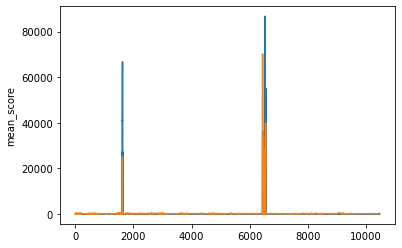

In [37]:
sns.lineplot(y=train_data[train_data.isTopPerformer == False]['mean_score'], x=train_data[train_data.isTopPerformer == False].index)
sns.lineplot(y=train_data[train_data.isTopPerformer == True]['mean_score'], x=train_data[train_data.isTopPerformer == True].index)

In [38]:
train_data.describe()

,studentId,createdDate,updatedDate,isExpelled,courseId,isFailed,startDate,mean_score,100_score,200_score,300_score,400_score,500_score,max_score,count_course,real_score,mean_weight
count,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,1.047100e+04,10471.000000,10471.000000,10471.000000
mean,7524.024448,194676.864005,195375.121860,0.646452,10.124248,0.137045,195530.736606,141.917905,3.598224,0.369019,0.105912,0.085570,0.068666,1.498156e+03,7.656671,123.642346,0.319933
std,4293.014788,4709.443432,4953.645634,0.478094,5.987661,0.343911,40186.944942,2137.133173,7.370031,1.401599,0.592821,0.529667,0.445248,3.066291e+04,13.027532,236.617973,0.722370
min,1.000000,190418.000000,190422.000000,0.000000,1.000000,0.000000,150101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,3108.500000,190503.000000,190805.000000,0.000000,2.000000,0.000000,190101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,7962.000000,190912.000000,191120.000000,1.000000,11.000000,0.000000,190909.000000,44.900000,0.000000,0.000000,0.000000,0.000000,0.000000,8.400000e+01,2.000000,100.000000,0.018000
75%,11153.500000,200204.000000,200802.000000,1.000000,13.000000,0.000000,200204.000000,80.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+02,10.000000,100.000000,0.467419
max,22877.000000,201004.000000,201013.000000,1.000000,27.000000,1.000000,700101.000000,86710.333333,62.000000,13.000000,7.000000,7.000000,7.000000,1.188820e+06,79.000000,1500.000000,10.000000


In [39]:
test_data.head()

,studentId,createdDate,updatedDate,isExpelled,courseId,isFailed,startDate,mean_score,100_score,200_score,300_score,400_score,500_score,max_score,count_course,real_score,mean_weight
0,11450,200205,200401,0.0,16,0.0,200205,224.500000,6.0,6.0,0.0,0.0,0.0,230.0,6.0,230.0,1.000000
1,7855,190911,191120,0.0,11,0.0,190909,80.722222,11.0,0.0,0.0,0.0,0.0,100.0,18.0,100.0,0.082778
2,12753,200217,201013,0.0,19,0.0,200217,100.000000,1.0,0.0,0.0,0.0,0.0,100.0,1.0,100.0,1.000000
3,14717,200718,200929,0.0,28,0.0,200718,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,7455,190910,200120,0.0,11,0.0,190909,99.166667,18.0,2.0,0.0,0.0,0.0,248.0,36.0,280.0,0.474722


In [40]:
#попробуем отбросить колонки 
#drop_train = train_data.drop(['studentId', 'courseId', 'startDate'], axis=1)
#drop_test = test_data.drop(['studentId', 'courseId', 'startDate'], axis=1)
#drop_train = train_data.drop(['courseId'], axis=1)
#drop_test = test_data.drop(['courseId'], axis=1)
drop_train = train_data
drop_test = test_data

In [41]:
# посмотрим на подготовленные данные
drop_train.describe()

,studentId,createdDate,updatedDate,isExpelled,courseId,isFailed,startDate,mean_score,100_score,200_score,300_score,400_score,500_score,max_score,count_course,real_score,mean_weight
count,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,10471.000000,1.047100e+04,10471.000000,10471.000000,10471.000000
mean,7524.024448,194676.864005,195375.121860,0.646452,10.124248,0.137045,195530.736606,141.917905,3.598224,0.369019,0.105912,0.085570,0.068666,1.498156e+03,7.656671,123.642346,0.319933
std,4293.014788,4709.443432,4953.645634,0.478094,5.987661,0.343911,40186.944942,2137.133173,7.370031,1.401599,0.592821,0.529667,0.445248,3.066291e+04,13.027532,236.617973,0.722370
min,1.000000,190418.000000,190422.000000,0.000000,1.000000,0.000000,150101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,3108.500000,190503.000000,190805.000000,0.000000,2.000000,0.000000,190101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,7962.000000,190912.000000,191120.000000,1.000000,11.000000,0.000000,190909.000000,44.900000,0.000000,0.000000,0.000000,0.000000,0.000000,8.400000e+01,2.000000,100.000000,0.018000
75%,11153.500000,200204.000000,200802.000000,1.000000,13.000000,0.000000,200204.000000,80.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+02,10.000000,100.000000,0.467419
max,22877.000000,201004.000000,201013.000000,1.000000,27.000000,1.000000,700101.000000,86710.333333,62.000000,13.000000,7.000000,7.000000,7.000000,1.188820e+06,79.000000,1500.000000,10.000000


In [42]:
drop_train.isna().sum()

studentId         0
createdDate       0
updatedDate       0
isExpelled        0
isTopPerformer    0
courseId          0
isFailed          0
startDate         0
mean_score        0
100_score         0
200_score         0
300_score         0
400_score         0
500_score         0
max_score         0
count_course      0
real_score        0
mean_weight       0
dtype: int64

In [43]:
# разделим искомое значение и тренировочные данные
y = drop_train['isTopPerformer']
drop_train = drop_train.drop('isTopPerformer', axis=1)

In [44]:
# Select categorical columns in training and testing data
cat_cols = [cname for cname in drop_train.columns if
                    drop_train[cname].dtype == "object"]
num_cols = [cname for cname in drop_train.columns if 
                drop_train[cname].dtype in ['int64', 'float64']]

In [45]:
cat_cols, num_cols

([],
 ['studentId',
  'createdDate',
  'updatedDate',
  'isExpelled',
  'courseId',
  'isFailed',
  'startDate',
  'mean_score',
  '100_score',
  '200_score',
  '300_score',
  '400_score',
  '500_score',
  'max_score',
  'count_course',
  'real_score',
  'mean_weight'])

In [46]:
pear_corr = drop_train[num_cols].corr(method='pearson')

<AxesSubplot:>

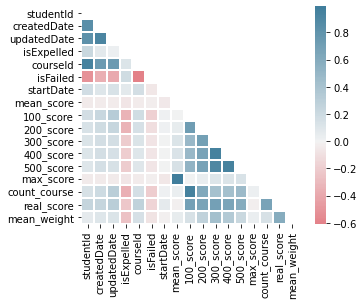

In [47]:
mask = np.triu(np.ones_like(pear_corr, dtype=bool))
cmap = sns.diverging_palette(10, 950, as_cmap=True)
sns.heatmap(pear_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 1})

In [48]:
upper = pear_corr.where(np.triu(np.ones(pear_corr.shape), k=1).astype(np.bool))
to_drop = [x for x in upper.columns if any(upper[x] > 0.98)]

In [49]:
to_drop

['max_score']

In [50]:
pear_corr

,studentId,createdDate,updatedDate,isExpelled,courseId,isFailed,startDate,mean_score,100_score,200_score,300_score,400_score,500_score,max_score,count_course,real_score,mean_weight
studentId,1.000000,0.843870,0.820096,0.217505,0.946417,-0.510797,0.177305,-0.039369,0.169849,0.139578,0.120028,0.113365,0.103419,-0.043286,0.142509,0.244731,0.072574
createdDate,0.843870,1.000000,0.926201,0.079271,0.746090,-0.354905,0.107884,-0.034694,0.227896,0.191500,0.166010,0.161134,0.156780,-0.039411,0.203036,0.243581,0.104212
updatedDate,0.820096,0.926201,1.000000,0.026006,0.745346,-0.382801,0.138715,-0.035215,0.320282,0.235696,0.163889,0.152664,0.148140,-0.040988,0.308789,0.305576,0.120446
isExpelled,0.217505,0.079271,0.026006,1.000000,0.115907,0.188987,0.077586,-0.068222,-0.332713,-0.332800,-0.204524,-0.197721,-0.202265,-0.063898,-0.348606,-0.226605,-0.262964
courseId,0.946417,0.746090,0.745346,0.115907,1.000000,-0.607293,0.164798,-0.033166,0.180950,0.151921,0.120497,0.108919,0.093206,-0.038387,0.159242,0.275283,0.148942
isFailed,-0.510797,-0.354905,-0.382801,0.188987,-0.607293,1.000000,-0.053846,-0.023736,-0.182249,-0.102152,-0.071200,-0.064384,-0.061461,-0.019174,-0.191612,-0.151960,-0.081228
startDate,0.177305,0.107884,0.138715,0.077586,0.164798,-0.053846,1.000000,-0.050765,0.016192,0.011622,0.006207,0.006266,0.005061,-0.051784,0.015669,0.069821,-0.013710
mean_score,-0.039369,-0.034694,-0.035215,-0.068222,-0.033166,-0.023736,-0.050765,1.000000,0.010008,0.052138,0.118810,0.125757,0.143573,0.990999,0.037462,-0.008302,0.052437
100_score,0.169849,0.227896,0.320282,-0.332713,0.180950,-0.182249,0.016192,0.010008,1.000000,0.724050,0.490606,0.488826,0.530919,0.000817,0.951690,0.694891,0.147997
200_score,0.139578,0.191500,0.235696,-0.332800,0.151921,-0.102152,0.011622,0.052138,0.724050,1.000000,0.703461,0.671239,0.678106,0.044354,0.620453,0.657991,0.274871


In [51]:
#drop_train.drop(to_drop, inplace=True, axis=1)
#drop_test.drop(to_drop, inplace=True, axis=1)

In [52]:
# Select categorical columns in training and testing data
cat_cols = [cname for cname in drop_train.columns if
                    drop_train[cname].dtype == "object"]
num_cols = [cname for cname in drop_train.columns if 
                drop_train[cname].dtype in ['int64', 'float64']]

In [53]:
# Break off validation set from training data
X_train, X_val, y_train, y_val = train_test_split(drop_train, y, test_size=0.2, random_state=0)

In [54]:
#parameters = {'loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              #'penalty':['l2', 'l1'],
              #'alpha':np.array([0.0001, 0.001, 0.1]),
              #'l1_ratio':np.array([0.6, 0.9, 0.01])
             #}

In [55]:
#c_model = SGDClassifier(random_state=0, penalty='elasticnet')
#clf = GridSearchCV(c_model, parameters, n_jobs=-1)

In [56]:
#clf.fit(X_train, y_train)
#clf.best_estimator_

In [57]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

selector = SelectFromModel(RandomForestRegressor(n_estimators=27, random_state=0))
#selector = SelectFromModel(SGDRegressor(random_state=0, penalty='elasticnet', l1_ratio=0.85))


model = SGDClassifier(random_state=0, loss='hinge', penalty='elasticnet', l1_ratio=0.78)
#model = KNeighborsClassifier(n_jobs=-1, weights='distance')
#model = SGDClassifier(alpha=0.1, loss='log', max_iter=500, n_jobs=-1, penalty='l1', random_state=0)

In [59]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('selector', selector),
                       ('model', model)])

In [60]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['studentId', 'createdDate',
                                                   'updatedDate', 'isExpelled',
                                                   'courseId', 'isFailed',
                                                   'startDate', 'mean_score',
                                                   '100_score', '200_score',
                                                   '300_score', '400_score',
                                                   '500_score', 'max_score',
                 

In [61]:
pipe.score(X_val, y_val)

0.9737470167064439

In [62]:
f1_score(y_val, pipe.predict(X_val)), cross_val_score(pipe, X_val, y_val, cv=5, scoring='f1').mean()

(0.9459193706981317, 0.9005977151827441)

In [63]:
cross_val_score(pipe, X_val, y_val, cv=5, scoring='f1')

array([0.91      , 0.90995261, 0.88349515, 0.9009901 , 0.89855072])

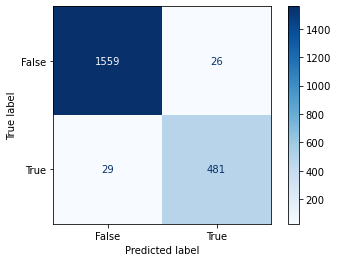

In [64]:
disp = plot_confusion_matrix(pipe, X_val, y_val,
                             cmap=plt.cm.Blues,
                             normalize=None)

In [65]:
submission = pd.DataFrame({
        "studentId": test_data.studentId,
        "isTopPerformer": pipe.predict(drop_test)
    })
submission.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
print(submission.tail(10))

Your submission was successfully saved!
      studentId  isTopPerformer
2981      14544           False
2982      15341            True
2983      15494           False
2984      13400           False
2985      13460           False
2986      13278           False
2987      14984           False
2988      14557           False
2989      15249           False
2990      15012           False
